<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
!pip install pygeohash
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install optuna

In [48]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()
import optuna
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [49]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train.csv', index_col=0)

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test.csv', index_col=0)

In [50]:
test_df

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons
4655,ROGER AOTSCHEGAROW,38.033040,-97.973170,1910 SOUTH BROADACRES ROAD,HUTCHINSON,KS,67501,RENO,20155.0,211112,NaN,"Natural Gas and Natural Gas Liquids Suppliers,...",NaN,NaN,NaN,NaN,88951.390376,65803.021457,2.899329e+04,32965.487915
4656,EPNG STATION 6543 LORDSBURG,32.316030,-108.606800,NaN,LORDSBURG,NM,88045,HIDALGO,35023.0,486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,3.119260e+05,268668.069110
4657,OWENS-BROCKWAY GLASS CONTAINER INC PLANT 19,41.251500,-78.742440,3831 ROUTE 219,BROCKPORT,PA,15823,JEFFERSON,42065.0,327213,NaN,Minerals,28275.061385,32075.140635,26445.792090,23385.161510,84908.372871,6212.899604,3.473291e+04,39045.247387
4658,WALDORF CORP (DBA ROCKTENN),44.959660,-93.193410,2250 WABASH AVE,SAINT PAUL,MN,551141895,RAMSEY,27123.0,322130,NaN,Pulp and Paper,37330.205714,42503.897432,43906.102080,42958.306538,49004.603631,52.038452,1.426237e+04,20204.924986
4659,SOLAR TURBINES INC KEARNY MESA,32.818720,-117.125800,4200 RUFFIN RD MZ T-2,SAN DIEGO,CA,92123,SAN DIEGO,6073.0,333611,NaN,Other,45310.722699,39897.800897,40203.428231,39437.099224,84959.769922,15351.359676,4.000654e+04,63935.249120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,BEULAH SANITARY LANDFILL,38.651945,-75.914445,ROUTE 331 & ROUTE 16- BEULAH ROAD,HURLOCK,MD,21643,DORCHESTER,24019.0,562212,NaN,Waste,NaN,NaN,NaN,NaN,110523.066755,98954.793233,3.467008e+06,147802.356027
7159,SONORA GAS PLANT,31.361795,-101.776403,NaN,RANKIN,TX,79778,UPTON,48461.0,211112,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7160,ASH GROVE CEMENT CO,41.005565,-96.154917,16215 HWY 50,LOUISVILLE,NE,680372881,CASS,31025.0,327310,NaN,Minerals,22956.125554,23592.402994,25069.498286,24560.172725,166520.232511,469732.826538,8.255855e+04,85775.307153
7161,SHOW ME ETHANOL LLC,39.364417,-93.449361,26530 E HWY 24,CARROLLTON,MO,64633,CARROLL,29033.0,325193,NaN,"Other,Waste",124460.895022,140816.449347,93118.705227,130326.946431,71773.803649,936031.894142,3.369613e+05,156640.371706


In [51]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['FacilityName', 'Latitude', 'Longitude', 'LocationAddress', 'City',
       'State', 'ZIP', 'County', 'FIPScode', 'PrimaryNAICS',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons'],
      dtype='object')

In [52]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [53]:
# del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df['FacilityName'], test_df['FacilityName']
del train_df['LocationAddress'], test_df['LocationAddress']
del train_df['ZIP'], test_df['ZIP']
del train_df['IndustryType'], test_df['IndustryType']
del train_df['SecondPrimaryNAICS'], test_df['SecondPrimaryNAICS']

In [54]:

two_digit_map     = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [55]:
train_df['first_two_digit_primary_naics'] = train_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)
test_df['first_two_digit_primary_naics']  = test_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)

train_df['Economic_Sector']               = train_df['first_two_digit_primary_naics'].map(two_digit_map)
test_df['Economic_Sector']                = test_df['first_two_digit_primary_naics'].map(two_digit_map)

del train_df['first_two_digit_primary_naics'], test_df['first_two_digit_primary_naics']

econ_sector_train                         = train_df['Economic_Sector'].values
econ_sector_test                          = test_df['Economic_Sector'].values

In [56]:
# NaNの数をカウントして 'num_missing' 列を作成
train_df["num_missing"] = train_df.isna().sum(axis=1)
test_df["num_missing"] = test_df.isna().sum(axis=1)

# 確認
train_df


,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,Economic_Sector,num_missing
0,40.141389,-87.581111,DANVILLE,IL,VERMILION,17183.0,326121,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,3.790794e+04,45598.125851,5.297314e+04,Manufacturing,0
1,38.475305,-81.278957,CLENDENIN,WV,KANAWHA,54039.0,486210,NaN,NaN,NaN,NaN,55507.543666,72387.334115,5.822520e+04,76376.547318,5.591007e+04,Transportation and Warehousing,4
2,39.299820,-80.857170,GREENWOOD,WV,RITCHIE,54085.0,211112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.567954e+04,"Mining, Quarrying, and Oil and Gas Extraction",8
3,35.490363,-119.042957,BAKERSFIELD,CA,KERN,6029.0,221112,NaN,NaN,NaN,NaN,54811.222708,69339.923002,6.364734e+04,53799.011225,6.141190e+04,Utilities,4
4,41.532802,-81.636448,CLEVELAND,OH,CUYAHOGA,39035.0,221112,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,7.739116e+04,17662.966241,4.310047e+04,Utilities,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,32.523334,-97.102556,VENUS,TX,JOHNSON,48251.0,211111,NaN,NaN,NaN,NaN,54978.841280,56463.765036,3.522786e+06,76642.640670,2.451197e+06,"Mining, Quarrying, and Oil and Gas Extraction",4
4651,42.684900,-109.780000,PINEDALE,WY,SUBLETTE,56035.0,211111,NaN,NaN,NaN,NaN,208375.435367,57066.624445,4.858030e+04,26892.366779,3.573974e+04,"Mining, Quarrying, and Oil and Gas Extraction",4
4652,35.484260,-97.498570,OKLAHOMA CITY,OK,OKLAHOMA,40109.0,611310,NaN,NaN,NaN,NaN,563756.090695,598881.479485,1.665103e+06,543206.073134,9.783592e+05,Educational Services,4
4653,39.404310,-76.319820,JOPPA,MD,HARFORD,24025.0,562213,NaN,NaN,NaN,NaN,67451.225733,27397.929966,3.922795e+04,46634.777768,2.723434e+04,Administrative and Support and Waste Managemen...,4


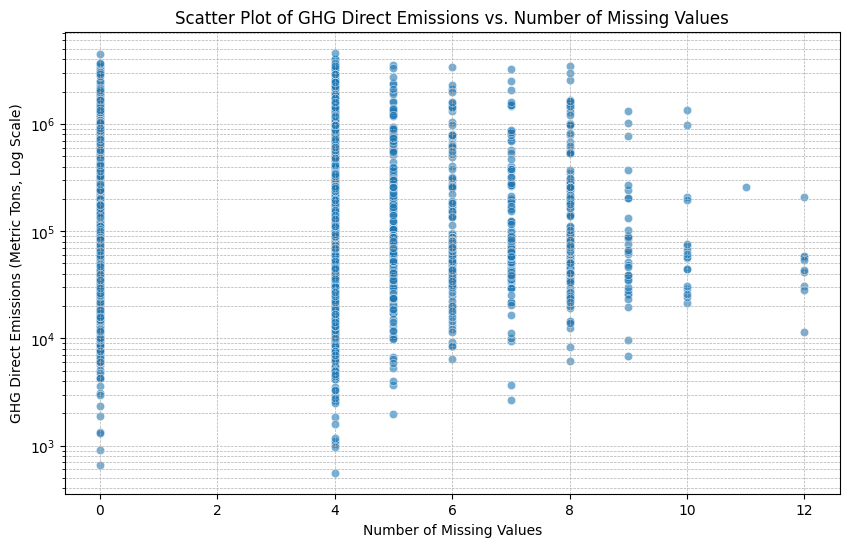

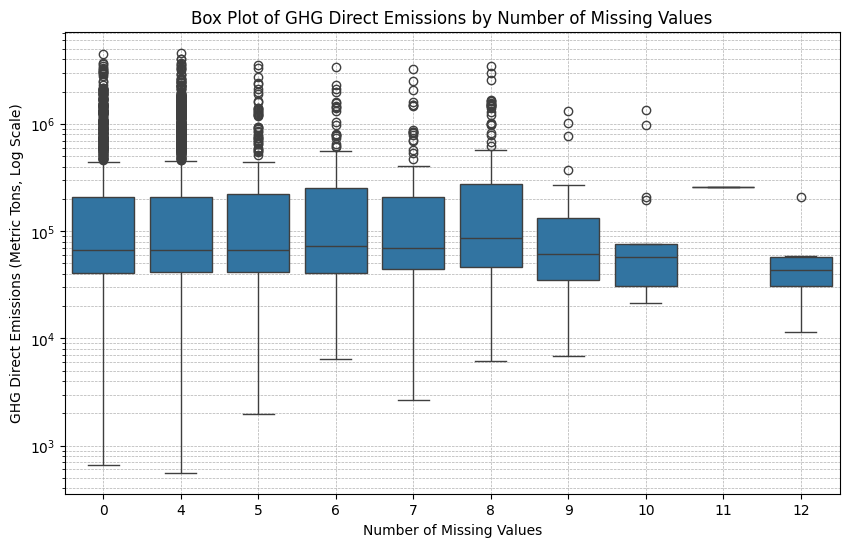

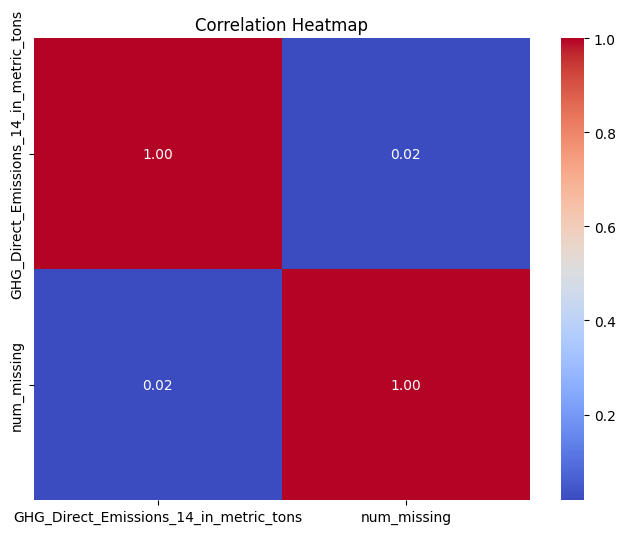

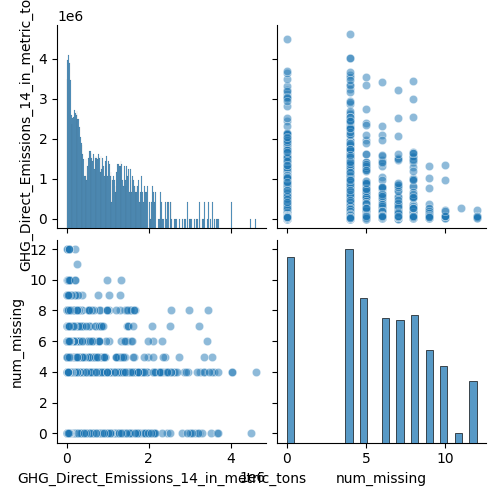

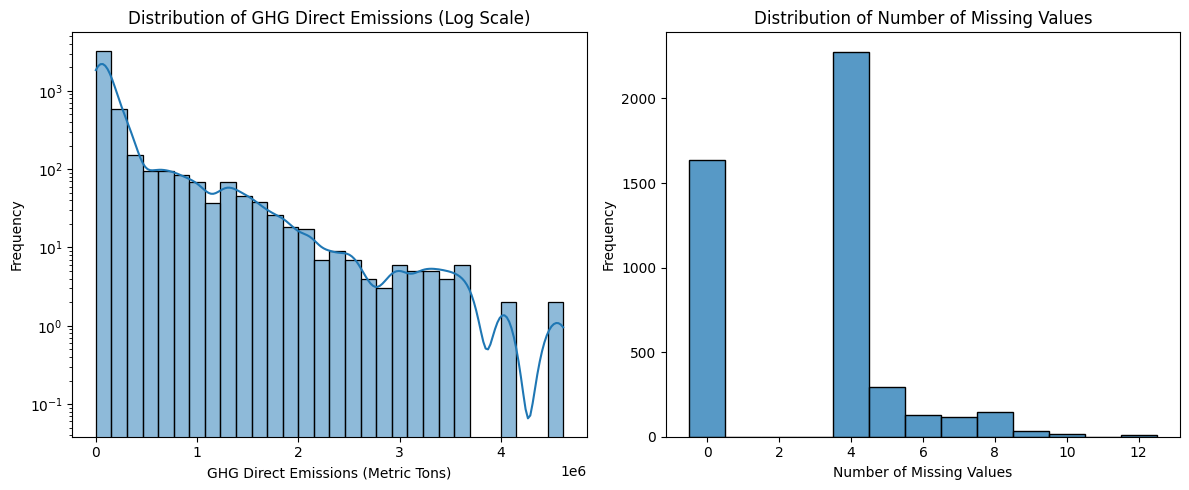

In [57]:
import seaborn as sns
filtered_train_df = train_df[train_df["GHG_Direct_Emissions_14_in_metric_tons"] > 0]
# 1. 散布図（Scatter Plot）
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_train_df,
    x="num_missing",
    y="GHG_Direct_Emissions_14_in_metric_tons",
    alpha=0.6
)
plt.yscale('log')  # Y軸を対数スケールに設定
plt.title("Scatter Plot of GHG Direct Emissions vs. Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("GHG Direct Emissions (Metric Tons, Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# 2. 箱ひげ図（Box Plot）
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_train_df,
    x="num_missing",
    y="GHG_Direct_Emissions_14_in_metric_tons"
)
plt.yscale('log')  # Y軸を対数スケールに設定
plt.title("Box Plot of GHG Direct Emissions by Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("GHG Direct Emissions (Metric Tons, Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# 3. ヒートマップ（Heatmap） - 相関行列の可視化
plt.figure(figsize=(8, 6))
correlation = filtered_train_df[["GHG_Direct_Emissions_14_in_metric_tons", "num_missing"]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 4. ペアプロット（Pair Plot） - 複数の視点からの可視化
sns.pairplot(filtered_train_df, vars=["GHG_Direct_Emissions_14_in_metric_tons", "num_missing"],
             kind='scatter', plot_kws={'alpha':0.5})
plt.yscale('log')
plt.show()

# 5. ヒストグラム（Histogram） - 各変数の分布
plt.figure(figsize=(12, 5))

# GHG_Direct_Emissions_14_in_metric_tons のヒストグラム（対数スケール）
plt.subplot(1, 2, 1)
sns.histplot(filtered_train_df["GHG_Direct_Emissions_14_in_metric_tons"], bins=30, kde=True)
plt.yscale('log')
plt.title("Distribution of GHG Direct Emissions (Log Scale)")
plt.xlabel("GHG Direct Emissions (Metric Tons)")
plt.ylabel("Frequency")

# num_missing のヒストグラム
plt.subplot(1, 2, 2)
sns.histplot(filtered_train_df["num_missing"], bins=range(filtered_train_df["num_missing"].max()+2), discrete=True, kde=False)
plt.title("Distribution of Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [58]:



def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of Earth in kilometers (mean radius)
    R = 6371.0

    # Calculate the distance
    distance = R * c
    return distance

In [59]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return haversine(lat1, lon1, lat2, lon2)

def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
    # Extract the required columns once to NumPy arrays
    latitudes = train_df['Latitude'].values
    longitudes = train_df['Longitude'].values
    ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
    econ_sectors = train_df['Economic_Sector'].values

    # Filter NaN emissions directly
    valid_indices = ~np.isnan(ghg_emissions)

    latitudes = latitudes[valid_indices]
    longitudes = longitudes[valid_indices]
    ghg_emissions = ghg_emissions[valid_indices]
    econ_sectors = econ_sectors[valid_indices]

    # Parallelize distance calculation using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        distances = list(executor.map(calculate_distance,
                                     [lat1]*len(latitudes),
                                     [lon1]*len(longitudes),
                                     latitudes,
                                     longitudes))

    # Combine the results into a DataFrame
    near_df = pd.DataFrame({
        'Distance': distances,
        'GHG_emission_14': ghg_emissions,
        'Economic_Sector': econ_sectors
    })


    if train_point:
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()
        near_df = near_df.iloc[1:].reset_index(drop=True)
    else:
        # Sort distances by 'Distance'
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()

    # Filter by economic sector
    nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

    # Get the top N nearest for both economic sector and overall
    sub_near_econ = nearest_locations_econ_sector.head(neighbours)
    sub_nearest_locations = near_df.head(neighbours)

    # Compute weighted averages
    econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
    near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

    # Compute regular averages
    econ_average = sub_near_econ['GHG_emission_14'].mean()
    near_average = sub_nearest_locations['GHG_emission_14'].mean()

    return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [60]:
# neighbours = 5

# # テストデータの距離計算または読み込み
# file_path = f"test_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists.")
#     test_distance = pd.read_csv(file_path)
# else:
#     output = []
#     for index in tqdm(range(test_df.shape[0])):
#         lat1 = test_df.iloc[index]['Latitude']
#         lon1 = test_df.iloc[index]['Longitude']
#         econ_sector_ref = test_df.iloc[index]['Economic_Sector']
#         x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=False)
#         output.append(x)

#     test_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average', 'Nearest_Weighted_Average', 'Nearest_Average'])
#     test_distance.to_csv(file_path, index=False)

# # トレーニングデータの距離計算または読み込み
# file_path = f"train_distance_{neighbours}nbrs.csv"  # f-string を正しく使用
# if os.path.exists(file_path):
#     print(f"{file_path} exists.")
#     train_distance = pd.read_csv(file_path)
# else:
#     output = []
#     for index in tqdm(range(train_df.shape[0])):
#         lat1 = train_df.iloc[index]['Latitude']
#         lon1 = train_df.iloc[index]['Longitude']
#         econ_sector_ref = train_df.iloc[index]['Economic_Sector']
#         x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=True)
#         output.append(x)

#     train_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average', 'Nearest_Weighted_Average', 'Nearest_Average'])
#     train_distance.to_csv(file_path, index=False)

train_distance = pd.read_csv(path+"train_distance_5nbrs.csv")
test_distance  = pd.read_csv(path+"test_distance_5nbrs.csv")

In [61]:
test_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Economic_Sector,num_missing
0,38.033040,-97.973170,HUTCHINSON,KS,RENO,20155.0,211112,NaN,NaN,NaN,NaN,88951.390376,65803.021457,2.899329e+04,32965.487915,"Mining, Quarrying, and Oil and Gas Extraction",4
1,32.316030,-108.606800,LORDSBURG,NM,HIDALGO,35023.0,486210,NaN,NaN,NaN,NaN,NaN,NaN,3.119260e+05,268668.069110,Transportation and Warehousing,6
2,41.251500,-78.742440,BROCKPORT,PA,JEFFERSON,42065.0,327213,28275.061385,32075.140635,26445.792090,23385.161510,84908.372871,6212.899604,3.473291e+04,39045.247387,Manufacturing,0
3,44.959660,-93.193410,SAINT PAUL,MN,RAMSEY,27123.0,322130,37330.205714,42503.897432,43906.102080,42958.306538,49004.603631,52.038452,1.426237e+04,20204.924986,Manufacturing,0
4,32.818720,-117.125800,SAN DIEGO,CA,SAN DIEGO,6073.0,333611,45310.722699,39897.800897,40203.428231,39437.099224,84959.769922,15351.359676,4.000654e+04,63935.249120,Manufacturing,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,38.651945,-75.914445,HURLOCK,MD,DORCHESTER,24019.0,562212,NaN,NaN,NaN,NaN,110523.066755,98954.793233,3.467008e+06,147802.356027,Administrative and Support and Waste Managemen...,4
2504,31.361795,-101.776403,RANKIN,TX,UPTON,48461.0,211112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Mining, Quarrying, and Oil and Gas Extraction",8
2505,41.005565,-96.154917,LOUISVILLE,NE,CASS,31025.0,327310,22956.125554,23592.402994,25069.498286,24560.172725,166520.232511,469732.826538,8.255855e+04,85775.307153,Manufacturing,0
2506,39.364417,-93.449361,CARROLLTON,MO,CARROLL,29033.0,325193,124460.895022,140816.449347,93118.705227,130326.946431,71773.803649,936031.894142,3.369613e+05,156640.371706,Manufacturing,0


In [62]:
test_distance

,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average
0,28019.568906,369614.866259,454847.563793,606222.120889
1,1296.575343,75372.922188,26392.933789,299096.231937
2,59857.420688,44340.597367,81533.914173,203831.976280
3,45265.635701,127292.222361,297072.418525,405635.394345
4,8838.742950,70847.235694,617665.034364,290001.288780
...,...,...,...,...
2503,46677.018970,344616.752313,45282.942220,309317.094507
2504,290186.877822,544751.143291,290186.877822,544751.143291
2505,102525.917615,658668.333532,100759.314574,598531.117832
2506,3259.275220,58047.779667,8262.408868,91773.030660


In [63]:
train_df.shape

(4655, 18)

In [64]:
train_df = pd.concat([train_df, train_distance], axis=1)
test_df = pd.concat([test_df, test_distance], axis=1)


In [65]:
def create_features1(df):


    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

   # Year-over-year growth rate with NaN protection
    df['TRI_Air_Emissions_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                 'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

In [66]:
def create_features2(df):


    # Year-over-year difference
    df['GHG_Direct_Emissions_YoY_Change_11'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_12'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_13'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']

    # Year-over-year growth rate for GHG Direct Emissions with NaN protection
    df['GHG_Direct_Emissions_Growth_Rate_11'] = np.where(
        df['GHG_Direct_Emissions_10_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_10_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']) / df['GHG_Direct_Emissions_10_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_12'] = np.where(
        df['GHG_Direct_Emissions_11_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_11_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']) / df['GHG_Direct_Emissions_11_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_13'] = np.where(
        df['GHG_Direct_Emissions_12_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_12_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']) / df['GHG_Direct_Emissions_12_in_metric_tons'],
        np.nan
    )

    return df


new_features2 = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                 'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                 ]
train_df      = create_features2(train_df)
test_df       = create_features2(test_df)

In [67]:
def create_features3(df):
    df['TRI_to_GHG_Ratio_10'] = np.where(df['GHG_Direct_Emissions_10_in_metric_tons'].notna(),
                                     df['TRI_Air_Emissions_10_in_lbs'] / df['GHG_Direct_Emissions_10_in_metric_tons'],
                                     np.nan)

    df['TRI_to_GHG_Ratio_11'] = np.where(df['GHG_Direct_Emissions_11_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_11_in_lbs'] / df['GHG_Direct_Emissions_11_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_12'] = np.where(df['GHG_Direct_Emissions_12_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_12_in_lbs'] / df['GHG_Direct_Emissions_12_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_13'] = np.where(df['GHG_Direct_Emissions_13_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_13_in_lbs'] / df['GHG_Direct_Emissions_13_in_metric_tons'],
                                        np.nan)
    return df



train_df      = create_features3(train_df)
test_df       = create_features3(test_df)
new_features3 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

In [68]:
summary_df = train_df.groupby(['Economic_Sector', 'State']).agg({'GHG_Direct_Emissions_14_in_metric_tons': ['mean', 'median', 'max', 'min','count']})

summary_df.columns = [
                        'GHG_Direct_Emissions_14_in_metric_tons_mean',
                        'GHG_Direct_Emissions_14_in_metric_tons_median',
                        'GHG_Direct_Emissions_14_in_metric_tons_max',
                        'GHG_Direct_Emissions_14_in_metric_tons_min',
                        'GHG_Direct_Emissions_14_in_metric_tons_count'
                     ]

summary_df = summary_df.reset_index()

train_df = train_df.merge(summary_df, on=['Economic_Sector', 'State'], how='left')
test_df  = test_df.merge(summary_df,  on=['Economic_Sector', 'State'], how='left')

In [69]:
test_df.shape

(2508, 42)

In [70]:
train_df.shape

(4655, 43)

In [71]:
merged_df = pd.concat((train_df,test_df),axis=0)
for cols in ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']:
    le              = LabelEncoder()
    merged_df[cols] = le.fit_transform(merged_df[cols].values.reshape(-1,1))

train_df = merged_df.iloc[:train_df.shape[0],:]
test_df  = merged_df.iloc[train_df.shape[0]:,:]
train_df.shape,test_df.shape

((4655, 43), (2508, 43))

In [72]:
numerical_columns = [
                    'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                    ]
lat_lon_columns   = ['Latitude','Longitude']
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']
train_aggregations  =  [
                        'GHG_Direct_Emissions_14_in_metric_tons_mean',
                        'GHG_Direct_Emissions_14_in_metric_tons_median',
                        'GHG_Direct_Emissions_14_in_metric_tons_max',
                        'GHG_Direct_Emissions_14_in_metric_tons_min',
                        'GHG_Direct_Emissions_14_in_metric_tons_count'
                     ]
new_features1  = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                    'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

new_features2   = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                  'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                  ]
new_features3   = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']
neighbour_feats = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average']


train = train_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                 +["num_missing"]
                 ].values
test  = test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                +["num_missing"]
                 ].values
target = train_df[target_columns].values


In [73]:
test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
        +["num_missing"]
                 ]


,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,4
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,6
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,4
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,8
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0


In [74]:
train_df["less_10^4"] = train_df["GHG_Direct_Emissions_14_in_metric_tons"].apply(lambda x: 1 if x < 10**4 else 0)
target_less_10_4 = train_df["less_10^4"].values



In [75]:
cat0 = CatBoostClassifier(
    iterations=864,
    depth=4,
    learning_rate=0.02,
    l2_leaf_reg=1.2322248317139508,
    border_count=254,
    bagging_temperature=0.1
)

cat0.fit(train, target_less_10_4, verbose=0)
oof_preds = cat0.predict_proba(train)
cat0_pred = cat0.predict_proba(test)

In [76]:
sum(cat0_pred[:, 1] > 0.16)

41

In [77]:
target

array([[ 52973.13994629],
       [ 55910.06661677],
       [ 55679.54321391],
       ...,
       [978359.18321926],
       [ 27234.34120387],
       [194822.07077126]])

In [78]:
tmp = 0
ave_less_10_4_log = 0
max(oof_preds[:, 1])
for i in range(len(oof_preds)):
    if oof_preds[i, 1] > 0.16 and target[i] < 10**4:
        ave_less_10_4_log += np.log1p(target[i])
        tmp += 1

ave_less_10_4_log /= tmp
print(ave_less_10_4_log)
ave_less_10_4 = np.expm1(ave_less_10_4_log)[0]
ave_less_10_4

[8.48907112]


4860.348375962864

In [79]:
def show_plot(test_preds, target):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(10, 7))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title('Comparison of Test Predictions and Target (Log Scale)')

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()

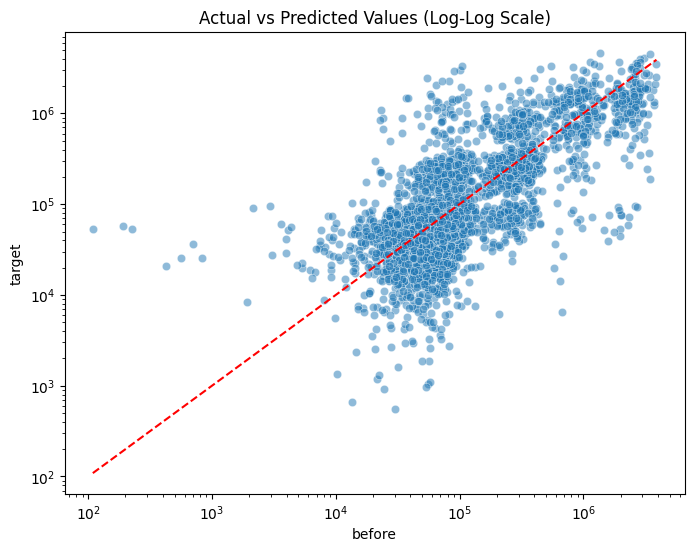

In [80]:
x=train_df["GHG_Direct_Emissions_10_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

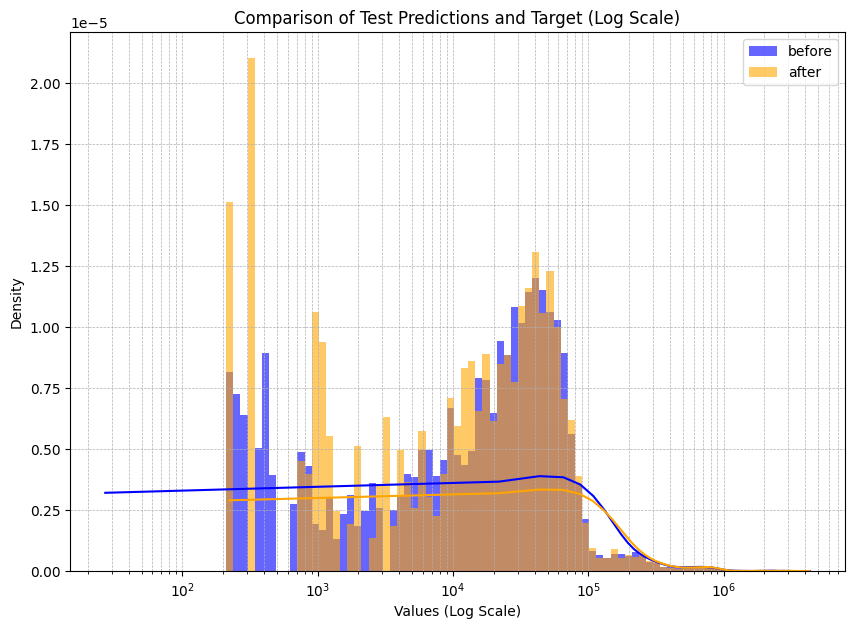

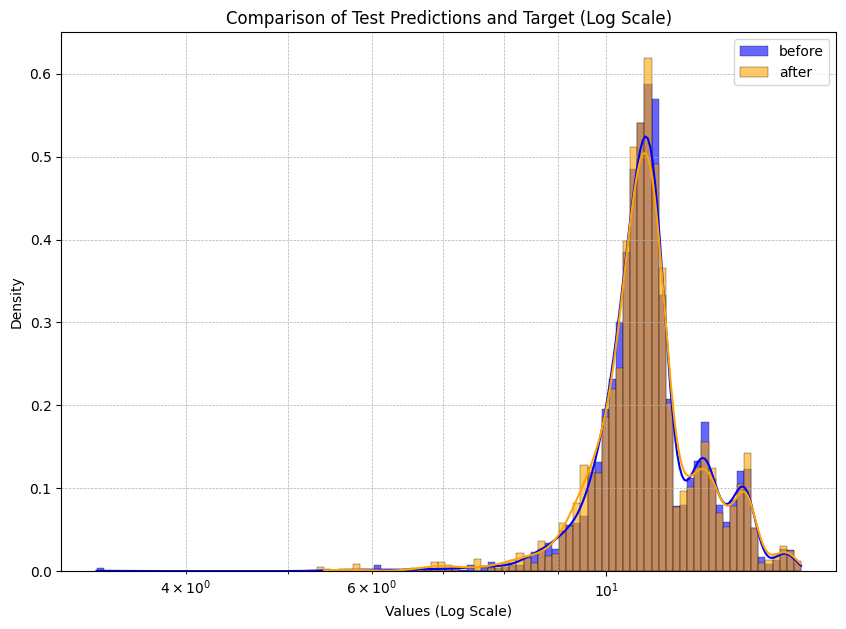

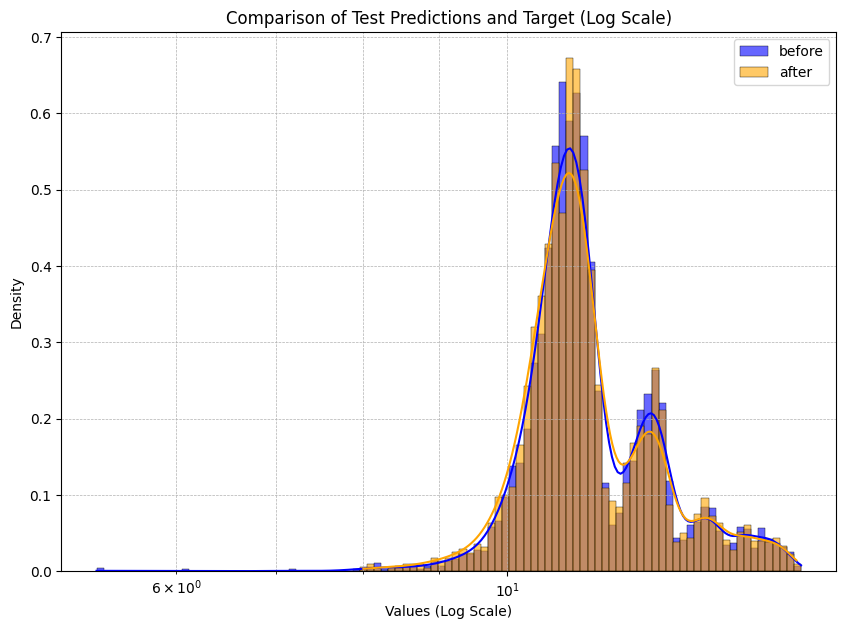

In [93]:
show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"], test_df["GHG_Direct_Emissions_13_in_metric_tons"])
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(test_df["GHG_Direct_Emissions_13_in_metric_tons"]))
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]), np.log(test_df["GHG_Direct_Emissions_12_in_metric_tons"]))

In [81]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params2 = {'iterations': 864,
                   'depth': 4,
                   'learning_rate': 0.02896173229206305,
                   'l2_leaf_reg': 1.2322248317139508,
                   'border_count': 254,
                   'bagging_temperature': 0.14851401382294827,
                   'random_strength': 0.9638662135548094,
                   'random_state': 42}
        model2 = CatBoostRegressor(**params2, verbose=0)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, np.log(np.log1p(y_train)))
            preds = np.exp(np.exp(model.predict(X_valid)))-1
            rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_log_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_log_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)

        test_predictions += test_preds / kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_log_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = np.expm1(test_predictions)

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions

In [82]:
oof_predictions,test_preds = get_models_trained(train,test,target,30)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.67693315817059
Fold 1 RMSLE for model2 = 0.6817806714786072
Fold 1 RMSLE for model3 = 0.6830642585499999
Fold 1 RMSLE for model4 = 0.6749147603409955
Fold 1 RMSLE for ('model1', 'model2') = 0.6767310063013224
Fold 1 RMSLE for ('model1', 'model3') = 0.6787572863273847
Fold 1 RMSLE for ('model1', 'model4') = 0.6737955240914726
Fold 1 RMSLE for ('model2', 'model3') = 0.6783867168886558
Fold 1 RMSLE for ('model2', 'model4') = 0.677438477034365
Fold 1 RMSLE for ('model3', 'model4') = 0.6751247327186453
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.6771166583573218
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.6753325782654754
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.6751049584679298
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.6759977034433343
Fold 1 RMSLE for all models ensemble = 0.6754854669943767
Fold 1 best combination: ('model1', 'model4') with RMSLE = 0.6737955240914726
---------------

Starting Fold 2
Fold 2 R

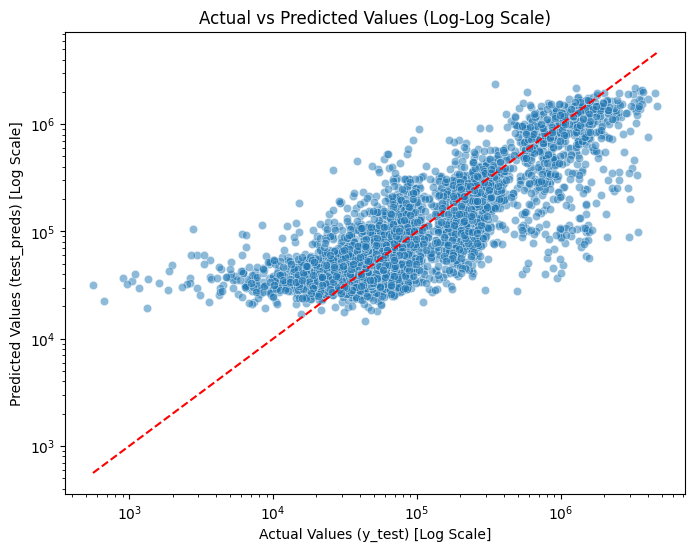

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
target = target.flatten()
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=target, y=oof_predictions, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([target.min(), target.max()], [target.min(), target.max()], 'r--')  # 45度線
plt.show()

In [84]:
# train_all = np.concatenate((train, test), axis=0)
# target_all = np.concatenate((target, test_preds), axis=0)
# oof_predictions,test_preds = get_models_trained(train_all,test,target_all,30)

In [85]:
submit = pd.read_csv(path+'sample_submission.csv',  header = None)
submit

,0,1
0,4655,249574.303827
1,4656,249574.303827
2,4657,249574.303827
3,4658,249574.303827
4,4659,249574.303827
...,...,...
2503,7158,249574.303827
2504,7159,249574.303827
2505,7160,249574.303827
2506,7161,249574.303827


In [86]:
test_preds.shape

(2508,)

In [87]:
submit [ 1 ]  =  test_preds
submit.to_csv('SMBC_20.csv', index = False)


In [88]:
submit

,0,1
0,4655,9.677540
1,4656,11.641482
2,4657,9.583844
3,4658,9.224606
4,4659,9.747550
...,...,...
2503,7158,12.108344
2504,7159,10.439667
2505,7160,10.820000
2506,7161,11.401274


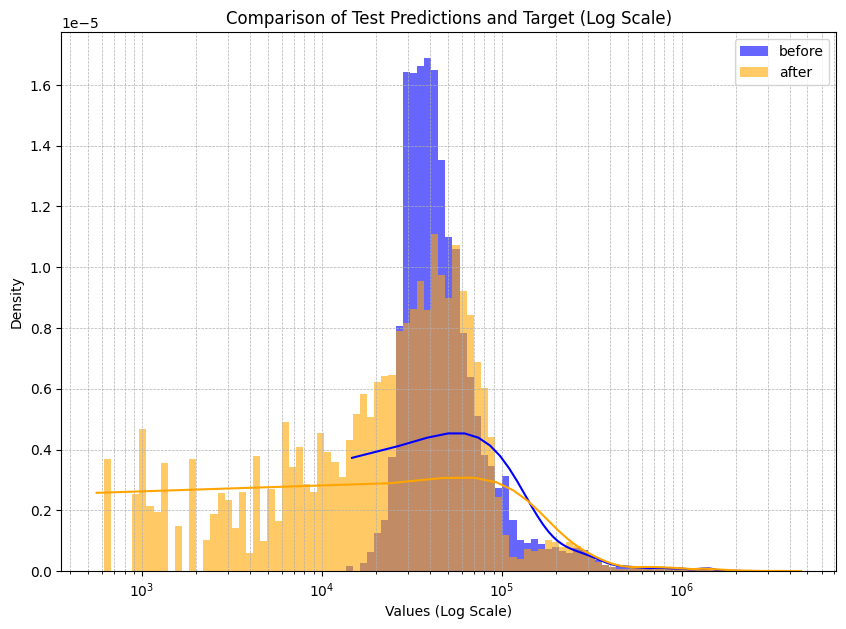

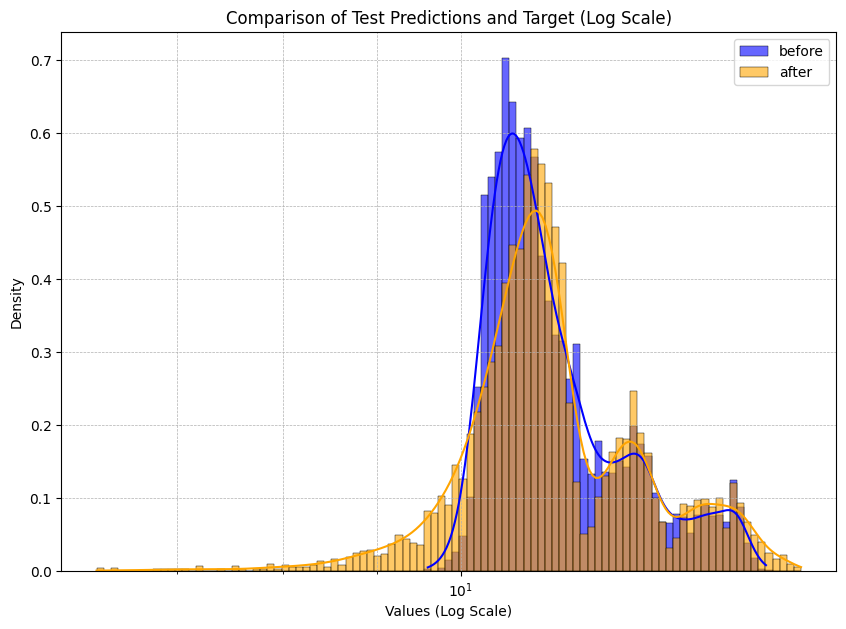

In [89]:

show_plot(oof_predictions, target)
show_plot(np.log(oof_predictions), np.log(target))

In [90]:
import time
print(time.ctime())

Wed Nov 20 15:12:16 2024
